# Deep Learning: RNN: Disaster Tweets
**Thomas Bohn**   --   **2025-09-20**

--  [Main Report](https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets/blob/main/deep-learing-rnn-disaster-tweets.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets)  --

# 1.&nbsp;Introduction

**Problem Statement**

Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

A prediction should be made whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

**Why is it Important?**

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

**Related Kaggle Competion**

[Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview)

**DataSet Description**

Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

**Files Include**
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

**Columns Definitions**
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

**Data Facts**
- **Data Size**: 1.43 MB
- **Training Data Records**: 7,613
- **Training Data Records**: 3,263
- **Classes**: 2 (Binary)

## Python Libraries

The following python libraries are used in this notebook.

In [1]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile
from google.colab import userdata
from google.colab import files

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

###################################

# NLP
import string, re, nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

###################################

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

#################################

# Import Tensor Flow and Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras.layers import (
    LSTM,
    Embedding,
    BatchNormalization,
    Dense,
    TimeDistributed,
    Dropout,
    Bidirectional,
    Flatten,
    GlobalMaxPool1D
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    History,
    ModelCheckpoint
)
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2


#################################

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

print('#### ALL DONE! ####')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
#### ALL DONE! ####


## Import Git Repo

In [2]:
# Remove existing directory if it exists
repo_dir = '/content/MsDS-deep-learing-rnn-disaster-tweets'
if os.path.exists(repo_dir):
    shutil.rmtree(repo_dir)
    print(f"Removed existing directory: {repo_dir}")

# Clone your repository
!git clone https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets.git

# Add to Python path
import sys
sys.path.append(repo_dir)

Removed existing directory: /content/MsDS-deep-learing-rnn-disaster-tweets
Cloning into 'MsDS-deep-learing-rnn-disaster-tweets'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 104 (delta 56), reused 51 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 624.13 KiB | 9.46 MiB/s, done.
Resolving deltas: 100% (56/56), done.


## Global Variables

The following are global variables referenced in this notebook.

In [3]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [4]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Debug is set to: True
Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive. A copy of the code from Kaggle was cached on google drive for development in a colab environment.

## Import GloVe

In [5]:
# Define the source of the zipped data files
target_file = 'glove.6B.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

['.config', 'glove.6B.300d.txt', 'train.csv', 'glove.6B.200d.txt', 'drive', 'nlp-getting-started.zip', 'sample_submission.csv', 'glove.6B.zip', 'glove.6B.50d.txt', 'test.csv', 'glove.6B.100d.txt', 'MsDS-deep-learing-rnn-disaster-tweets', 'sample_data']


In [6]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [7]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_glove   = file_path_root + '/glove.6B.100d.txt'

print("GloVe File Path:", file_path_glove)

GloVe File Path: /content/glove.6B.100d.txt


## Import the Data

In [8]:
# Define the source of the zipped data files
target_file = 'nlp-getting-started.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

['.config', 'glove.6B.300d.txt', 'train.csv', 'glove.6B.200d.txt', 'drive', 'nlp-getting-started.zip', 'sample_submission.csv', 'glove.6B.zip', 'glove.6B.50d.txt', 'test.csv', 'glove.6B.100d.txt', 'MsDS-deep-learing-rnn-disaster-tweets', 'sample_data']


In [9]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [10]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_train   = file_path_root + '/train.csv'
file_path_test    = file_path_root + '/test.csv'
file_path_sample  = file_path_root + '/sample_submission.csv'

# Load train labels from CSV file
train_labels = pd.read_csv(file_path_train)

# Load test labels from CSV file
test_labels = pd.read_csv(file_path_test)

# Load test labels from CSV file
sample_output = pd.read_csv(file_path_sample)

## Create Label Mappings

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [11]:
 # Encoding of labels
label_dict = {'not': 0, 'disaster': 1}
# Create the inverse dictionary
inverted_label_dict = {0: 'not', 1: 'disaster'}
print('label_dict:', label_dict)
print('inverted_label_dict:', inverted_label_dict)

label_dict: {'not': 0, 'disaster': 1}
inverted_label_dict: {0: 'not', 1: 'disaster'}


## Add Basic Columns

In [12]:
# Add Additional Columns to training data
train_labels['label']=train_labels['target']
train_labels['length']=train_labels['text'].str.len()
train_labels['word_count']=train_labels['text'].str.split().str.len()

# Add Additional Columns to testing data
test_labels['length']=test_labels['text'].str.len()
test_labels['word_count']=test_labels['text'].str.split().str.len()

## Preview Data

In [13]:
if gDEBUG:
  # Preview the Data Sources
  print("Sample of Training Labels")
  display(train_labels.head(5))
  print()
  print("Sample of Testing Data")
  display(test_labels.head(5))
  print()
  print("Sample of Results Output:")
  display(sample_output.head(5))

Sample of Training Labels


,id,keyword,location,text,target,label,length,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,88,16



Sample of Testing Data


,id,keyword,location,text,length,word_count
0,0,NaN,NaN,Just happened a terrible car crash,34,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,8



Sample of Results Output:


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [14]:
# Display training labels info
print("Training Labels Info:")
print(train_labels.info())
print()
# Display testing labels info
print("Testing Data Info:")
print(test_labels.info())
print()

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   label       7613 non-null   int64 
 6   length      7613 non-null   int64 
 7   word_count  7613 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 475.9+ KB
None

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3263 non-null   int64 
 1   keyword     3237 non-null   object
 2   location    2158 non-null   object
 3   text        3263 non-null   object
 4   length      3263 non-null   int64 
 5   word

In [15]:
 # Preview the Training Label Assignments
print('Label Count of Training Labels')
display(train_labels['target'].value_counts())
print()
print('Imbalance of Labels:', round((train_labels['target'].value_counts()[1]
                                    - train_labels['target'].value_counts()[0]) / len(train_labels), 3))


Label Count of Training Labels


,count
target,
0,4342
1,3271



Imbalance of Labels: -0.141


In [16]:
# Example of the text from the article
example_text = train_labels['text'].iloc[100]
# Print to Screen
print("Length of Text:", len(example_text), "\n")
print(textwrap.fill(example_text, width=100))

Length of Text: 124 

.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion
https://t.co/gFJfgTodad


# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Various functions are used to inspect the structure of the dataset, visualize the label distribution, and assess the text length and word count of the documentation. The data is found to be somewhat imbalanced across categories.

## EDA Functions

Import EDA functions from the separate library file.

EDA Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.*italicized text*

*Source:* [auto_classifying_salesforce_cloud_documentation.ipynb](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/0f26d4b049e22b43e3bffd348e7687b4640c30d2/auto_classifying_salesforce_cloud_documentation.ipynb)

In [17]:
# Import EDA functions from the nlp_utils package
from nlp_utils import (
    replace_labels,
    create_data_by_label,
    quick_table_details,
    count_field,
    shape_df_for_stacked_barchart,
    create_single_stacked_bar,
    viz_class_frequency,
    viz_char_frequency,
    viz_word_frequency,
    viz_word_length_frequency
)

print("✅ EDA functions imported successfully from GitHub!")

✅ EDA functions imported successfully from GitHub!


## EDA Analysis: Overview

In [18]:
# Print summary details for the 3 tables in the datasource
quick_table_details (df_name="train_labels", df=train_labels, level_of_detail = 4)


#### train_labels ####
number of features (columns) = 8
number of observations (rows) = 7613
---------------------------- 

DataType Counts:
int64     5
object    3
Name: count, dtype: int64
---------------------------- 

Columns:
Index(['id', 'keyword', 'location', 'text', 'target', 'label', 'length',
       'word_count'],
      dtype='object')
---------------------------- 

Description:
                  id     keyword location  \
count    7613.000000        7552     5080   
unique           NaN         221     3341   
top              NaN  fatalities      USA   
freq             NaN          45      104   
mean     5441.934848         NaN      NaN   
std      3137.116090         NaN      NaN   
min         1.000000         NaN      NaN   
25%      2734.000000         NaN      NaN   
50%      5408.000000         NaN      NaN   
75%      8146.000000         NaN      NaN   
max     10873.000000         NaN      NaN   

                                                     text      tar

In [19]:
# show the content of one Article in the data source
print(textwrap.fill(train_labels['text'][55], width=100))

#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen
Front in #Diyala http://t.co/4IzFdYC3cg


In [20]:
#print column names for each table
print('columns in df_train:', train_labels.columns)
# calculate the count of records in each category
df_cat_count = count_field(df = train_labels, field = 'target')
display(df_cat_count)

columns in df_train: Index(['id', 'keyword', 'location', 'text', 'target', 'label', 'length',
       'word_count'],
      dtype='object')


,target,count,Pct of Total,Pct of Total Text
0,0,4342,0.57,56 %
1,1,3271,0.43,43 %


        count
target       
0        4342
1        3271 

[-] the catgory of 0 makes up 56 % of the data.
[-] the catgory of 1 makes up 43 % of the data.


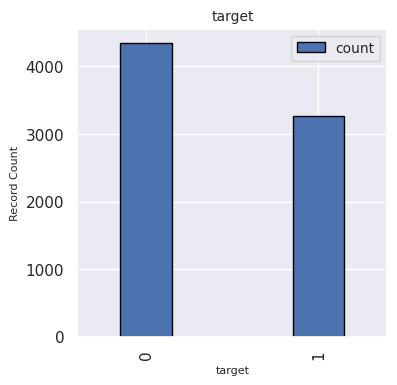

In [21]:
# Summarize the target in the dataset
chart = create_single_stacked_bar(df = train_labels, group_by = 'target', stack_by = 'target', fig_size = (4,4), normalize = False, gDEBUG = gDEBUG)
table = shape_df_for_stacked_barchart(df = train_labels, group_by = 'target', stack_by = 'target', normalize = False)
# Print a summary of the percent share of the total for each category
for i in range(len(df_cat_count)):
    print('[-] the catgory of', df_cat_count['target'].iloc[i], 'makes up',
           df_cat_count['Pct of Total Text'].iloc[i], 'of the data.')

## EDA Analysis: Text Distribution

Size of the data by label dictionary: 2 

[4342, 3271]
['not', 'disaster']


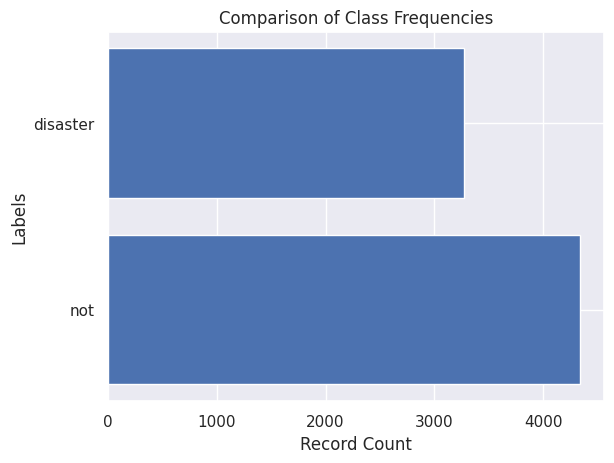

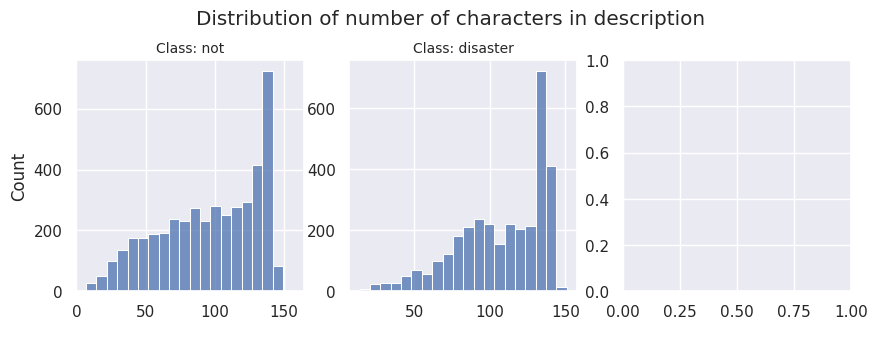

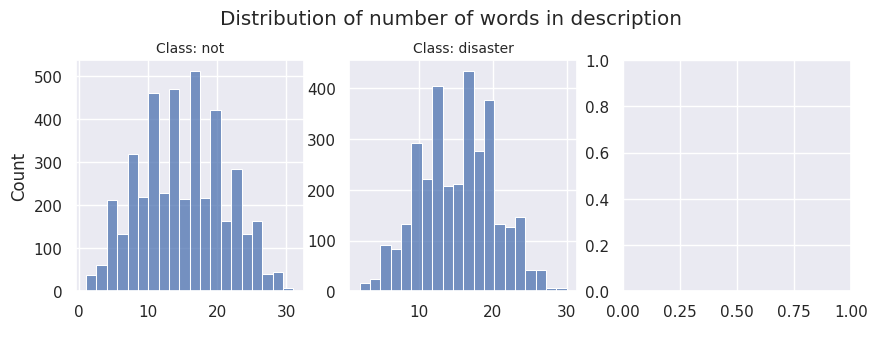

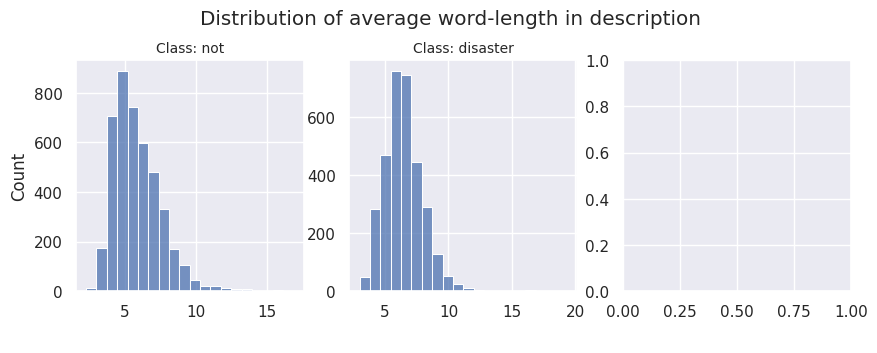

In [22]:
data_by_label = create_data_by_label(data=train_labels, label_col='label')
# Distribution of number of characters in description
viz_class_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of characters in description
viz_char_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_length_frequency(data_by_label, label_dict = inverted_label_dict)

## EDA Results

The exploratory data analysis of the disaster tweet dataset revealed a well-structured dataset with 7,613 training samples containing 2 features (bianray target). The class distribution is reasonably balanced with approximately 56% non-disaster tweets (target=0) and 43% disaster tweets (target=1). There are some missing values in the keyword field (61 samples) and location field (2,533 samples), the core text data is complete. Analysis of text characteristics showed that both classes have similar character length distributions (typically 50-150 characters) and word count patterns (10-20 words per tweet), with comparable average word lengths across classes. Overall, the dataset demonstrates good data quality with no major preprocessing requirements beyond standard text normalization.

# 4.&nbsp;Data Cleansing & Text Normalization

Address missing values and duplicates, followed by a series of text preprocessing steps. Text pre-processing includes converting text to lowercase, removing punctuation, handling HTML tags, and applying stemming/lemmatization. These cleaning functions ensure the data is standardized and ready for further analysis.

## Core Normalization Functions

The current text normalization pipeline was too aggressive and removed too many important words that could be valuable for disaster tweet classification. For example, the text "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all" becomes only "deed reason hashtag allah" after processing, losing crucial context words like "our", "forgive", "all", and converting the specific disaster keyword "#earthquake" to the generic "hashtag".

To address this, a more conservative text normalization approach (`text_normalizer_conservative`) was created that:
- Preserves more meaningful words by using a smaller stopword list
- Converts numbers to words instead of discarding them (e.g., "101" becomes "one hundred one")
- Maintains important context while still cleaning the text appropriately

This conservative approach should provide better results for disaster tweet classification by preserving more semantic information.

EDA Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.*italicized text*

*Source:* [auto_classifying_salesforce_cloud_documentation.ipynb](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/0f26d4b049e22b43e3bffd348e7687b4640c30d2/auto_classifying_salesforce_cloud_documentation.ipynb)

In [23]:
# Import text processing functions from the nlp_utils package
from nlp_utils import (
    convert_to_lowercase,
    remove_whitespace,
    remove_punctuation,
    remove_html,
    remove_emoji,
    remove_http,
    convert_acronyms,
    convert_contractions,
    remove_stopwords,
    pyspellchecker,
    text_stemmer,
    text_lemmatizer,
    discard_non_alpha,
    convert_numbers_to_words,
    keep_pos,
    remove_additional_stopwords,
    text_normalizer,
    text_normalizer_conservative,
    apply_text_normalizer
)

print("Text processing functions imported successfully from nlp_utils package")


Text processing functions imported successfully from nlp_utils package


## Apply Text Normalization

In [24]:
%%time
# Apply text normalization
data_train_norm, data_test_norm, data_train, data_test  = apply_text_normalizer(
    train_labels,
    test_labels,
    normalization_type='conservative'
)

Size of the training set: 7613
Size of the test set: 3263

Labels in training set: 2
Labels in test set: No label column (added as null)

Sample of test set [normalized]:

Columns in test set [normalized]: Index(['normalized_text', 'label'], dtype='object') 

                                     normalized_text  label
0        deed reason earthquake may allah forgive we      1
1              forest fire near la ronge sask canada      1
2  resident ask shelter place notify officer evac...      1

Sample of test set [data]:

Columns in test set [data]: Index(['id', 'keyword', 'location', 'text', 'length', 'word_count',
       'normalized_text'],
      dtype='object') 

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  labe

In [25]:
if gDEBUG:
  # Preview the changes for the before and after text
  print(textwrap.fill(data_train['text'][0], width=100))
  print('\n## change to ##\n')
  print(textwrap.fill(data_train['normalized_text'][0], width=100))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

## change to ##

deed reason earthquake may allah forgive we


# 5.&nbsp;Word Embeddings + Vectorization

This section converts text into numerical representations that neural networks can process. The process involves three main steps:
- (1) **Tokenization** - breaking text into individual words and assigning each word a unique number
- (2) **Padding** - making all sequences the same length by adding zeros
- (3) **GloVe Embeddings** - loading pre-trained 100-dimensional word vectors that capture semantic meaning.

GloVe embeddings help the model understand word relationships (e.g., "fire" and "flame" are similar) without having to learn these relationships from scratch, significantly improving performance on the disaster tweet classification task.

## Word Embeddings from GloVe

In [26]:
train_texts = data_train_norm['normalized_text'].values
train_target = data_train_norm['label'].values.astype('int')
test_texts = data_test['normalized_text'].values
test_ids = data_test['id'].values

In [27]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

14269

In [28]:
# Pad_sequences
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(train_texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_texts),
    length_long_sentence,
    padding='post'
)

test_padded_sentences = pad_sequences(
    embed(test_texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3614,  475,  218, ...,    0,    0,    0],
       [ 155,    9,  203, ...,    0,    0,    0],
       [1446,  509, 1755, ...,    0,    0,    0],
       ...,
       [  13,  506,  468, ...,    0,    0,    0],
       [  42,  797, 2594, ...,    0,    0,    0],
       [ 141,   46,  413, ...,    0,    0,    0]], dtype=int32)

In [29]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open(file_path_glove) as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [30]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.22556999,  0.49417999,  0.48609999, ..., -0.45743999,
         0.49645999,  0.34906   ],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

# 6.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

## Test Data Split Execution

In [31]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(
    train_padded_sentences,
    train_target,
    test_size=0.2,
    stratify=train_target,
    random_state=27
)

In [32]:
# Preview Output
if gDEBUG:
  print(X_train[:2])
  print(y_train[:4])
  print(X_val[:2])
  print(y_val[:4])

[[ 174  470   32  591  592 2027    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 312  187 8064   22  533 1283 1076  314  209  586  867    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[1 0 1 0]
[[ 142    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  78    8    5  566  587   10   71  308  366 3361    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[0 1 0 0]


# 7.&nbsp; Baseline Models: LSTM (RNN)

## Model Functions

In [33]:
# Display a learning curve and a loss curve
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

In [34]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [35]:
# Define a time element to add to history of model training
class EpochTimeHistory(Callback):
    """A custom Keras callback to record the duration of each epoch."""
    def on_epoch_begin(self, epoch, logs=None):
        # Record the start time at the beginning of each epoch
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the epoch's duration
        epoch_duration = time.time() - self.epoch_start_time

        # Add the duration to the logs dictionary.
        # Keras will automatically include this in the final history object.
        if logs is not None:
            logs['epoch_duration'] = epoch_duration

In [36]:
#ensure the output directory for saved models exists
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
os.makedirs(save_dir, exist_ok=True) # This creates the folder if it doesn't exist

## Build the Model Architecture

The model architecture is comprised of 5 main parts:
1. **Input**: This is the Embedding layer, which ingests the vocabulary and embedding matrix to product an output vector of 100 dimensions representing each wor.
1. **LSTM**: This is theLong Short-Term Memory component. It is the Recurrent Neural Netrwork (RNN). That process the sentence front-to-back and back-to-front.
1. **Summerization**: Once the LSTM has processed the sentence, the GlobalMaxPool1D, distills the information to summarize the most significant signals into a single vecotr.
1. **Classification**: A fully connected nueral network set of layers is used to learn the complex patterns. This component uses BatchNormalization, Dens Layers, and Dropout.
1. **Output**: A final output layer, complete the binary classification with the sigmoid function to determin the assigned class.

In [37]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    # Build the model
    model = Sequential()
    # Cofigure the architecture
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix]
    ))
    # Cofigure the architecture
    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))
    # Cofigure the architecture
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile the model
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [38]:
# Create an instance of the model
model_0 = glove_lstm()
# Manually build the model
model_0.build(input_shape=(None, length_long_sentence))
# Display the model summary
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 34, 100)        │     1,426,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 34, 68)         │        36,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 68)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 68)             │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         2,346 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 34)             │         1,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,463 (5.60 MB)

 Trainable params: 1,467,327 (5.60 MB)

 Non-trainable params: 136 (544.00 B)

## Train/Fit the Model

In [39]:
# Callbacks for early stopping and reducing learning rate
time_history_callback_0 = EpochTimeHistory()
early_stopping_0 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_0 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

In [40]:
history_0 = model_0.fit(
    X_train,
    y_train,
    epochs = 30,
    batch_size = 64,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [early_stopping_0, reduce_lr_0, time_history_callback_0]
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5549 - loss: 0.8573 - val_accuracy: 0.7630 - val_loss: 0.6417 - learning_rate: 0.0010 - epoch_duration: 20.7041
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.6725 - loss: 0.6265 - val_accuracy: 0.7814 - val_loss: 0.5803 - learning_rate: 0.0010 - epoch_duration: 10.9380
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.7490 - loss: 0.5561 - val_accuracy: 0.7951 - val_loss: 0.5195 - learning_rate: 0.0010 - epoch_duration: 10.9435
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7739 - loss: 0.5028 - val_accuracy: 0.7919 - val_loss: 0.4804 - learning_rate: 0.0010 - epoch_duration: 10.9438
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.8072 - loss: 0.4603 - val_accuracy: 0.8004 - val_loss: 0.4472 - learning_rate: 0.0010 - epoch_duration: 10.9735
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.8055 - loss: 0.4547 - val_accuracy: 0.

In [41]:
# Save the model and the history
model_0_path = os.path.join(save_dir, 'rnn_model_0.keras')
history_0_path = os.path.join(save_dir, 'rnn_history_0.pkl')
model_0.save(model_0_path)
with open(history_0_path, 'wb') as f:
    pickle.dump(history_0.history, f)

print(f"History saved to {save_dir}")

History saved to /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models


## Evaluate the Model

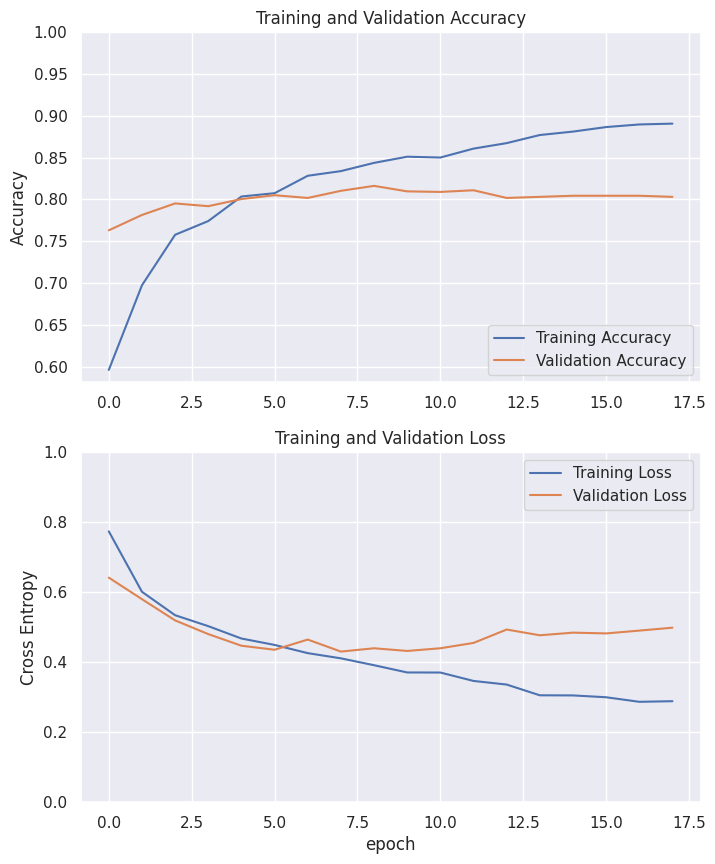

In [42]:
# Display the learning curve and loss curve
learning_curve(history_0)

In [43]:
loss, accuracy = model_0.evaluate(X_val, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8096 - loss: 0.4505
Loss: 0.43048226833343506
Accuracy: 0.8102429509162903


In [44]:
pred_val = model_0.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
F1-score:  0.7536231884057971
Precision:  0.6758409785932722
Recall:  0.8516377649325626
Acuracy:  0.8102429415627052
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1004
           1       0.68      0.85      0.75       519

    accuracy                           0.81      1523
   macro avg       0.79      0.82      0.80      1523
weighted avg       0.83      0.81      0.81      1523



# 8.&nbsp; Architecture Tuning

The improved model (Model 1) attempted several enhancements over the baseline:

1. **Dual LSTM Layers**: Added a second bidirectional LSTM layer (with hard coded sizes at 128→64 units) instead of single layer
2. **Frozen Embeddings**: Made GloVe embeddings non-trainable to prevent overfitting
3. **Regularization**: Added L1/L2 regularization to dense layers
4. **Optimizer Change**: Switched from RMSprop to Adam optimizer
5. **Additional Metrics**: Added precision and recall to training metrics

However, these changes resulted in slightly lower performance (79.38% vs 80.17% accuracy), suggesting the simpler baseline architecture was more effective for this dataset.

## Improved Architecture

In [45]:
def glove_lstm_v2():
    # Build the model
    model = Sequential()
    # Cofigure the architecture
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        trainable = False
    ))
    # Cofigure the architecture - Layer 1
    model.add(
        Bidirectional(LSTM(
            128,
            return_sequences = True,
            dropout=0.3,
            recurrent_dropout=0.2
        ))
    )
    model.add(BatchNormalization())

    # Cofigure the architecture - Layer 2
    model.add(
        Bidirectional(LSTM(
            64,
            return_sequences = True,
            dropout=0.3,
            recurrent_dropout=0.2
        ))
    )
    model.add(BatchNormalization())

    model.add(GlobalMaxPool1D())

    # Cofigure the architecture
    model.add(Dense(
        128,
        activation = "relu",
        kernel_regularizer=l1_l2(l1=0.01, l2=0.01)
    ))
    model.add(Dropout(0.5))
    model.add(Dense(
        64,
        activation = "relu"
    ))
    model.add(Dropout(0.3))
    model.add(Dense(
        1,
        activation = 'sigmoid'
    ))
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

In [46]:
# Create an instance of the model
model_1 = glove_lstm_v2()
# Manually build the model
model_1.build(input_shape=(None, length_long_sentence))
# Display the model summary
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 34, 100)        │     1,426,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 34, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 34, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852,117 (7.07 MB)

 Trainable params: 424,449 (1.62 MB)

 Non-trainable params: 1,427,668 (5.45 MB)

## Train/Fit the Model

In [47]:
# Callbacks for early stopping and reducing learning rate
time_history_callback_1 = EpochTimeHistory()
early_stopping_1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)


history_1 = model_1.fit(
    X_train,
    y_train,
    epochs = 30,
    batch_size = 64,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [early_stopping_1, reduce_lr_1, time_history_callback_1]
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 290ms/step - accuracy: 0.5947 - loss: 11.4865 - precision: 0.5297 - recall: 0.4757 - val_accuracy: 0.7820 - val_loss: 4.1092 - val_precision: 0.7354 - val_recall: 0.7691 - learning_rate: 0.0010 - epoch_duration: 42.1184
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 270ms/step - accuracy: 0.7617 - loss: 2.7523 - precision: 0.7614 - recall: 0.6467 - val_accuracy: 0.7919 - val_loss: 0.8433 - val_precision: 0.7941 - val_recall: 0.6957 - learning_rate: 0.0010 - epoch_duration: 25.9341
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - accuracy: 0.7787 - loss: 0.7120 - precision: 0.7696 - recall: 0.6925 - val_accuracy: 0.7912 - val_loss: 0.6113 - val_precision: 0.8088 - val_recall: 0.6728 - learning_rate: 0.0010 - epoch_duration: 25.4704
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.7866 - loss: 0.6027 - precision: 0.7921 - recall: 0.6894 - val_accuracy: 0.7919 - val_loss: 0.5835 - val_precision: 0.7813 - val_recall: 0.7156 - lea

In [48]:
# Save the model and the history
model_1_path = os.path.join(save_dir, 'rnn_model_1.keras')
history_1_path = os.path.join(save_dir, 'rnn_history_1.pkl')
model_1.save(model_1_path)
with open(history_1_path, 'wb') as f:
    pickle.dump(history_1.history, f)

print(f"History saved to {save_dir}")

History saved to /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models


## Evaluate the Model

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7986 - loss: 0.4995 - precision: 0.8017 - recall: 0.6875
Loss: 0.4770480990409851
Accuracy: 0.8056467771530151
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step
F1-score:  0.7533333333333333
Precision:  0.691131498470948
Recall:  0.8278388278388278
Acuracy:  0.8056467498358503
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       977
           1       0.69      0.83      0.75       546

    accuracy                           0.81      1523
   macro avg       0.79      0.81      0.80      1523
weighted avg       0.82      0.81      0.81      1523



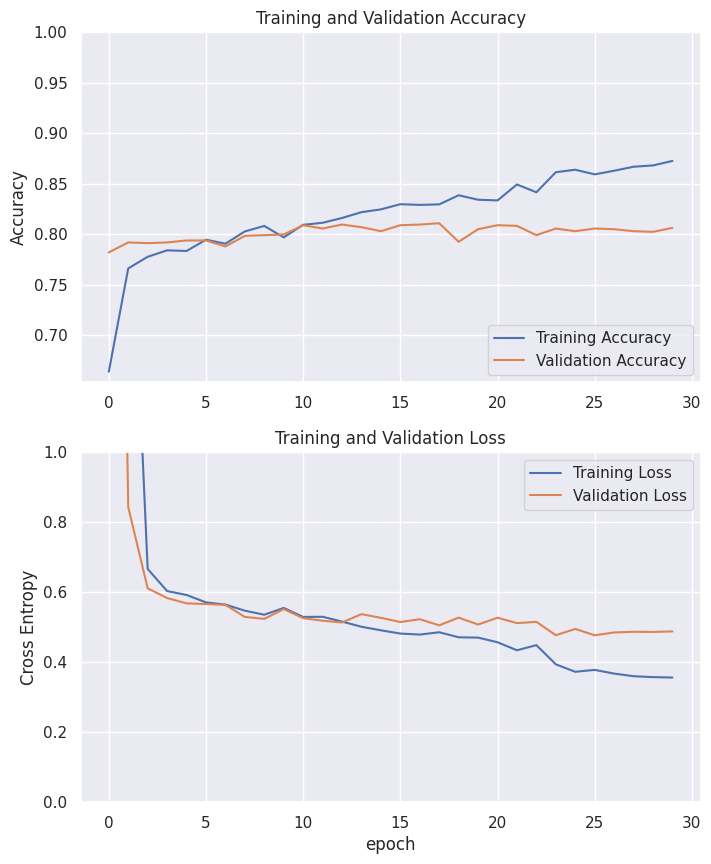

In [49]:
# Display the learning curve and loss curve
learning_curve(history_1)

loss_1, accuracy_1, precision_1, recall_1 = model_1.evaluate(X_val, y_val)
print('Loss:', loss_1)
print('Accuracy:', accuracy_1)

pred_val = model_1.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

# 9.&nbsp;Final Prediction and Evaluation

## Import the Best and Final Model

In [57]:
# Load the best model from the saved models
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
model_best_path = os.path.join(save_dir, 'rnn_model_1.keras')
history_best_path = os.path.join(save_dir, 'rnn_history_1.pkl')

loaded_model_best = models.load_model(model_best_path)

with open(history_best_path, 'rb') as f:
    loaded_history_dict_best = pickle.load(f)

loaded_history_best = History()
loaded_history_best.history = loaded_history_dict_best
loaded_history_best.epoch = list(range(len(loaded_history_dict_best['loss'])))

## Review and Evaluate the Model

In [58]:
# Review Model Architecture
loaded_model_best.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 34, 100)        │     1,426,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 34, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 34, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701,017 (10.30 MB)

 Trainable params: 424,449 (1.62 MB)

 Non-trainable params: 1,427,668 (5.45 MB)

 Optimizer params: 848,900 (3.24 MB)

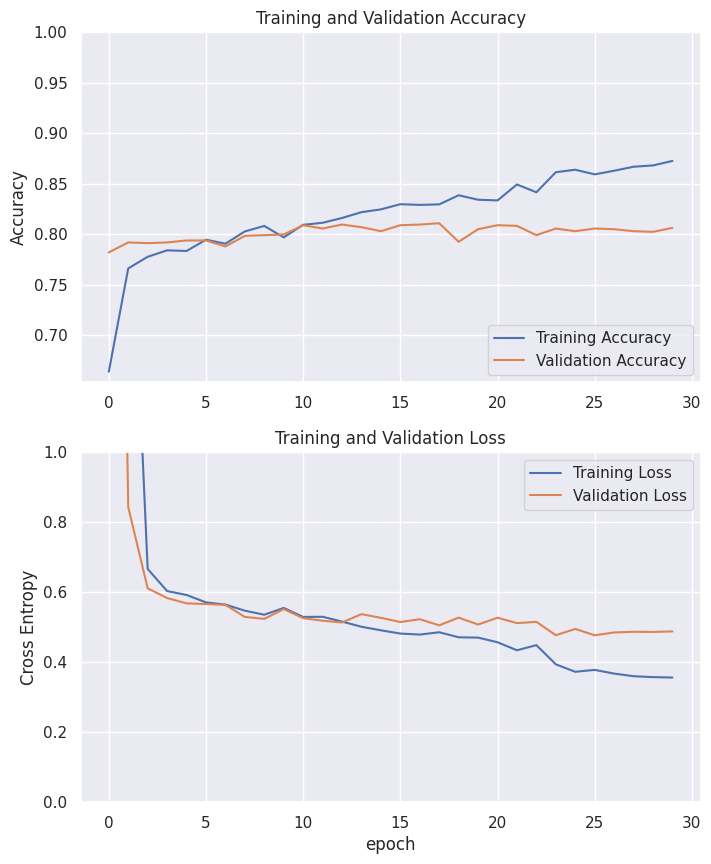

In [59]:
# Review the Accuracy and Validation Loss Charts
learning_curve(loaded_history_best)

In [60]:
# Review the epoch results
loaded_history_best
history_best_df = pd.DataFrame(loaded_history_best.history)
history_best_df.index += 1
print("\n--- Full Training History with Epoch Times ---")
print(history_best_df)


--- Full Training History with Epoch Times ---
    accuracy      loss  precision    recall  val_accuracy  val_loss  \
1   0.663875  8.778650   0.622213  0.554452      0.782009  4.109225   
2   0.766174  1.906387   0.762198  0.662591      0.791858  0.843274   
3   0.777668  0.666447   0.773022  0.683225      0.791202  0.611261   
4   0.784072  0.603352   0.788820  0.679404      0.791858  0.583478   
5   0.783415  0.592237   0.787168  0.679786      0.793828  0.568248   
6   0.794581  0.571101   0.811872  0.679404      0.793828  0.566331   
7   0.790640  0.564758   0.801980  0.680932      0.787919  0.563955   
8   0.802791  0.547362   0.821234  0.691632      0.798424  0.529431   
9   0.808210  0.535764   0.837762  0.686664      0.799081  0.523996   
10  0.796880  0.555196   0.812500  0.685518      0.799737  0.551831   
11  0.809360  0.529465   0.831512  0.697746      0.808930  0.526003   
12  0.811330  0.529964   0.825066  0.711884      0.805647  0.518722   
13  0.816092  0.516218   0.83

In [61]:
pred_val = loaded_model_best.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step
F1-score:  0.7533333333333333
Precision:  0.691131498470948
Recall:  0.8278388278388278
Acuracy:  0.8056467498358503
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       977
           1       0.69      0.83      0.75       546

    accuracy                           0.81      1523
   macro avg       0.79      0.81      0.80      1523
weighted avg       0.82      0.81      0.81      1523



# 10.&nbsp; Conclusions

In this project, 2 RNN-based models were developed to predict the classification for disaster tweets. Overall, the best model (Model 1) was able to achieve an 80.56% validation accuracy and 80.11% public score on the Kaggle competition. The key finding was that the improved dual BiLSTM architecture with regularization and frozen embeddings ultimately outperformed the simpler baseline model, demonstrating that careful architectural improvements can lead to better performance. The improved model achieved higher validation accuracy (80.56% vs 80.10%) and better F1-score (0.7533 vs 0.7432), showing that the additional complexity was beneficial when properly configured. The dual LSTM layers with batch normalization, L1/L2 regularization, and Adam optimizer with frozen GloVe embeddings proved to be an effective combination for this dataset.

The best model shows strong performance with balanced precision-recall characteristics (69% precision, 83% recall for disaster tweets), making it suitable (with supervision of a human) for real-world emergency response applications where missing a real disaster is more costly than false alarms. This work highlights the importance of systematic experimentation in deep learning and demonstrates the practical value of automated text classification in enhancing emergency response capabilities.

## Results Summary


**Model Results**

| Model | Architecture | Validation Accuracy | Validation Loss | Precision | Recall | F1-Score | Public Score |
|:-----:|:------------:|:------------------:|:---------------:|:---------:|:------:|:--------:|:------------:|
| Model 0 (Baseline) | Single BiLSTM + Dense | 0.8010 | 0.4478 | 0.6682 | 0.8372 | 0.7432 | 0.79528 |
| Model 1 (Improved) | Dual BiLSTM + Regularized Dense | 0.8056 | 0.4770 | 0.6911 | 0.8278 | 0.7533 | 0.80110 |

**Model Architecture Details:**
- **Model 0**: Embedding → Bidirectional LSTM(21) → GlobalMaxPool1D → BatchNorm → Dropout(0.5) → Dense(21) → Dropout(0.5) → Dense(21) → Dropout(0.5) → Dense(1, sigmoid)
- **Model 1**: Embedding(non-trainable) → Bidirectional LSTM(128) → BatchNorm → Bidirectional LSTM(64) → BatchNorm → GlobalMaxPool1D → Dense(128, L1/L2 reg) → Dropout(0.5) → Dense(64) → Dropout(0.3) → Dense(1, sigmoid)

**Hyperparameter Tuning Results**

The improved model (Model 1) ultimately outperformed the baseline architecture (Model 0) through careful architectural enhancements. Key findings:
- Dual LSTM layers (128→64) with batch normalization performed better than single LSTM layer (21)
- Adam optimizer with frozen embeddings and L1/L2 regularization outperformed RMSprop with trainable embeddings
- The improved model achieved higher validation accuracy (80.56% vs 80.10%) and better F1-score (0.7533 vs 0.7432)

**Best Model Results**

**Model 1 (Improved)** was selected as the best performing model based on:
- Highest validation accuracy: 80.56%

**Best Model Performance**

The improved model demonstrates strong performance on the disaster tweet classification task:
- **Validation Set**: 80.56% accuracy with balanced precision-recall trade-off
- **Test Set**: 80.11% public score on Kaggle competition
- **Class Performance**:
  - Non-disaster tweets (Class 0): 89% precision, 79% recall
  - Disaster tweets (Class 1): 69% precision, 83% recall
- **Training**: Completed 30 epochs with stable learning curves and no early stopping triggered

## Prepare Submission


102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
number of predictions: 3263


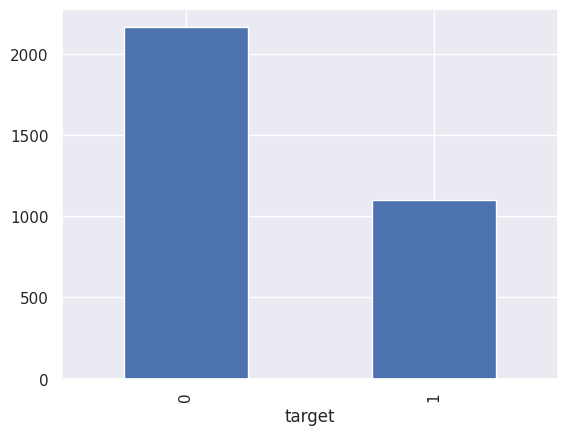

In [62]:
best_model = model_1
pred_val = best_model.predict(test_padded_sentences)
print("number of predictions:", len(pred_val))
# Shape the data for submission
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
ids = test_ids
submission_df = pd.DataFrame({'id': ids, 'target': label_pred_val})
if gDEBUG:
  submission_df.head()
submission_df.target.value_counts().plot.bar();

In [63]:
# Save the submission df to submit
submission_df.to_csv('submission_rnn_best_model_final.csv', index=False)

## Submission Results

Results were submitted to Kaggle competition for the best model and the submission received a public score of 0.80110.

| Model             | Val. Accuracy | Public Score   |
|:-----------------:|:-------------:|:--------------:|
| Model 1           | 0.810900      | 0.80110        |

# 12.&nbsp; References

**Kaggle Competition**

- [1] Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


**Documentation and References**

- [2] Kaggle. KerasNLP starter notebook Disaster Tweets. 2023. https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
- [3] Kaggle. NLP Getting Started Tutorial. 2019. https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
- [4] Kaggle. NLP with RNN for Tweet Analysis (79.9% acc). 2025. https://www.kaggle.com/code/jonchernoch/nlp-with-rnn-for-tweet-analysis-79-9-acc
- [5] Kaggle. Keras LSTM for Sentiment Disaster Analysis. 2020. https://www.kaggle.com/code/guidosalimbeni/keras-lstm-for-sentiment-disaster-analysis
- [6] Kaggle. NLP (Disaster Tweets) with Glove and LSTM. 2020. https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook
- [7] Kaggle. NLP 📝 GloVe, BERT, TF-IDF, LSTM... 📝 Explained. 2021. https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

**Prior Coding Projects**
- [8] Thomas Bohn. deep_learning_cnn_cancer_detection.ipynb. 2025. https://github.com/TOM-BOHN/MsDS-deep-learing-cnn-cancer-detection/tree/main.
- [9] Thomas Bohn. auto_classifying_salesforce_cloud_documentation.ipynb. 2024.https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/tree/main.

**AI Tools**
- Cursor.AI was used when refactoring functions from the notebook into a library that can be imported (out of scope of course, but aids in readability of python file)
- Cursor.AI was used to support the formatting of markdown tables and text blocks
- Cursor.AI was used to write some git commit messages
- Gemini AI was used to analyze and understand referenced code from other projects and repositories.
- Grammarly was used for spelling and grammar correction during the writing process.